In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import argparse
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from models.soft_shift_net.soft_shiftnet_model import ShiftNetModel
from options.train_options import TrainOptions 
from models import networks
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [2]:
import util
from util.util import *
from collections import namedtuple 

In [3]:
optClass = namedtuple('Options', ['fineSize'])

In [4]:
opt = optClass(fineSize=256)
opt.fineSize

256

In [5]:
%time mask = wrapper_gmask(opt)

CPU times: user 408 ms, sys: 12 ms, total: 420 ms
Wall time: 217 ms


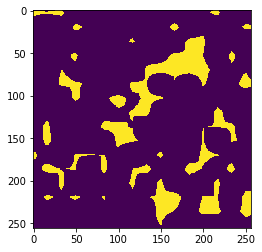

In [6]:
plt.imshow(np.squeeze(mask))

In [7]:
import skimage
from skimage.transform import resize

In [8]:
masks = []
for _ in range(1000):
    mask = wrapper_gmask(opt).cpu().numpy()
    masks.append(resize(np.squeeze(mask), (64, 64)))
masks = np.array(masks)

In [9]:
#masks = masks.reshape((1000, -1))

In [10]:
mean = np.mean(masks) 
masks[masks >= mean] = 1
masks[masks < mean] = 0

In [11]:
masks.shape

(1000, 64, 64)

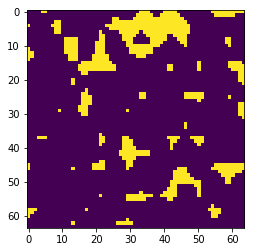

In [12]:
plt.imshow(masks[0])

In [13]:
masks = masks.astype(np.int)
masks = masks.reshape((1000, -1))

In [14]:
class OptimizerMask:
    
    def __init__(self, masks, stop_criteria=0.85):
        self.masks = masks
        self.indexes = []
        self.stop_criteria = stop_criteria
        
        
    def get_iou(self):
        intersection = np.matmul(masks, masks.T)
        diag = np.diag(intersection)
        outer_add = np.add.outer(diag, diag)
        self.iou = intersection / outer_add 
        self.shape = self.iou.shape
        
    def _is_finished(self):
        masks = self.masks[self.indexes]
        #print(masks.shape)
        masks = np.sum(masks, axis=0)
        #print(masks.shape)
        masks[masks > 0] = 1
        plt.imshow(masks.reshape((64, 64)))
        area_coverage = np.sum(masks)/np.product(masks.shape)
        #print(area_coverage)
        if area_coverage < self.stop_criteria:
            return False
        else:
            return True
        
    def mean(self):
        _mean = np.mean(np.sum(self.masks[self.indexes], axis=-1))/(64*64)
        print(_mean)
        
    def _get_next_indexes(self):
        ious = self.iou[self.indexes]
        _mean_iou = np.mean(ious, axis=0)
        idx = np.argmin(_mean_iou)
        #print(idx)
        self.indexes = np.append(self.indexes, np.argmin(_mean_iou))
        
    def _solve(self):
        self.indexes = list(np.unravel_index(np.argmin(self.iou), self.shape))
        #print(self.indexes)
        while not self._is_finished():
            self._get_next_indexes()
            
    def get_masks(self):
        masks = self.masks[self.indexes]
        full = np.ones_like(masks[0])
        left = full - np.mean(masks, axis=0)
        return np.append(masks, left).reshape((-1, 64, 64))
    
    def solve(self):
        self._solve()
        

In [15]:
opti = OptimizerMask(masks)

In [16]:
opti.get_iou()

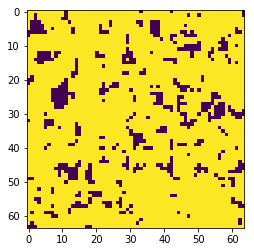

In [17]:
opti.solve()

In [18]:
opti.mean()

0.08539496527777778


In [19]:
output = opti.get_masks()

In [20]:
output.shape

(19, 64, 64)

In [21]:
masks = np.array([resize(mask, (256, 256)) for mask in output])

In [22]:
masks[masks > 0] = 1

In [23]:
masks[-1] = 1 - np.max(masks[:-1], axis=0)

In [24]:
masks[-1]

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

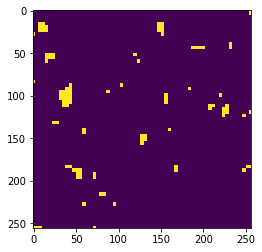

In [25]:
plt.imshow(masks[-1])

In [26]:
from skimage.morphology import *

In [27]:
masks[-1] = dilation(masks[-1], diamond(5))

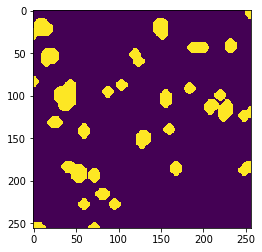

In [28]:
plt.imshow(masks[-1])

# DEFINE THE MODEL

In [29]:
dataroot = '/mnt/hdd2/AIM/DAGM/Class4_def' # ENTER HERE THE PATH YOU WANT TO USE AS DATAROOT
#dataroot = '/mnt/hdd2/AIM/DAGM/Class8/Train' # ENTER HERE THE PATH YOU WANT TO USE AS DATAROOT
which_model_netG = 'unet_shift_triple'
model = 'shiftnet'
dataset_mode = 'aligned_resized'
which_model_netD = 'basic'
gpu_ids = '3'
fixed_mask = '0'
mask_type = 'random'
options = '--dataroot {} --which_model_netG {} --model {} --dataset_mode {} --which_model_netD {} --gpu_ids {} --fixed_mask {} --mask_type {}'\
            .format(dataroot, which_model_netG, \
                    model, dataset_mode, which_model_netD, gpu_ids, fixed_mask, mask_type).split(' ')

In [30]:
def get_parser(options=None):
    parser = TrainOptions()
    parser.parse(options=options)
    return parser

In [31]:
parser = get_parser(options=options)
opt = parser.opt

----------------- Options ---------------
       add_mask2input_dis: 1                             
       add_mask2input_gen: 1                             
                batchSize: 1                             
                    beta1: 0.5                           
               bottleneck: 512                           
          checkpoints_dir: ./log                         
                constrain: MSE                           
           continue_train: False                         
                 dataroot: /mnt/hdd2/AIM/DAGM/Class4_def 	[default: ./datasets/Paris/train]
             dataset_mode: aligned_resized               	[default: aligned]
             display_freq: 100                           
               display_id: 1                             
            display_ncols: 5                             
             display_port: 8097                          
           display_server: http://localhost              
display_single_pane_ncols: 0       

In [32]:
from models import create_model
from collections import OrderedDict

In [33]:
model = create_model(opt)

shiftnet
define_G [4, 3, 64, 'unet_shift_triple', tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:3', dtype=torch.uint8), 'instance', False, 'normal', [3], 0.02] []
get_norm_layer [] ['norm_type']
input_nc 4
output_nc 3
which_model_netG unet_shift_triple
[CREATED] MODEL
UnetSkipConnectionBlock(
  (model): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace)
    (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
)
[CREATED] MODEL
Constraint in netG:
[InnerCos(skip: True ,strength: 1)]
Shift in netG:
[InnerShiftTriple( ,triple_weight 1)]
initialize network with

In [34]:
os.listdir('/mnt/hdd2/AIM/checkpoints/')

['20_12_2018_Class4_0',
 '3_01_2019_Class4_1',
 '17_12_2018_Class7_0',
 'class3_b16',
 'class4_0',
 'class4_basic_b8',
 '3_01_2019_Class4_2',
 '4_1_19_c4.1',
 '22_12_2018_Class3_3',
 'class3_basic_b8',
 '20_12_2018_Class3_1',
 '3_01_2019_Class3_0',
 '17_12_2018_Class10_0',
 'class3_1',
 '20_12_2018_Class3_2',
 '3_01_2019_Class4_3',
 '20_12_2018_Class3_0',
 '4_1_19_c4.0',
 '14_12_2018_1_Class4_0',
 '17_12_2018_Class8_0',
 '14_12_2018_2_Class5_0',
 'class4_1',
 '14_12_2018_Class2_0',
 '17_12_2018_Class10_1',
 '17_12_2018_Class9_0',
 '14_12_2018_Class3_1',
 'class4_2',
 '14_12_2018_1_Class3_1',
 'class3_basic_b4',
 '20_12_2018_Class3_3',
 '14_12_2018_Class3_0',
 '22_12_2018_Class4_0',
 '3_01_2019_Class4_0',
 'batch_8',
 'class3_0',
 '14_12_2018_Class5_0',
 'results']

In [109]:
path_weights = '/mnt/hdd2/AIM/checkpoints/3_01_2019_Class4_3/latest_net_G.pth'

In [110]:
weights = torch.load(path_weights)

In [111]:
keys = list([k for k,v in weights.items() if v.dim() == 4])
keys

['model.model.0.weight',
 'model.model.1.model.1.weight',
 'model.model.1.model.3.model.1.weight',
 'model.model.1.model.3.model.3.model.1.weight',
 'model.model.1.model.3.model.3.model.3.model.1.weight',
 'model.model.1.model.3.model.3.model.3.model.3.model.1.weight',
 'model.model.1.model.3.model.3.model.3.model.3.model.3.model.1.weight',
 'model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.1.weight',
 'model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.3.weight',
 'model.model.1.model.3.model.3.model.3.model.3.model.3.model.5.weight',
 'model.model.1.model.3.model.3.model.3.model.3.model.5.weight',
 'model.model.1.model.3.model.3.model.3.model.5.weight',
 'model.model.1.model.3.model.3.model.5.weight',
 'model.model.1.model.3.model.7.weight',
 'model.model.1.model.5.weight',
 'model.model.3.weight']

In [112]:
new_state = OrderedDict()
for k in weights.keys():
    new_k = 'module.'+k
    new_state[new_k] = weights[k]

In [113]:
keys_m = list([k for k,v in model.netG.state_dict().items() if v.dim() == 4])
keys_m

['module.model.model.0.weight',
 'module.model.model.1.model.1.weight',
 'module.model.model.1.model.3.model.1.weight',
 'module.model.model.1.model.3.model.3.model.1.weight',
 'module.model.model.1.model.3.model.3.model.3.model.1.weight',
 'module.model.model.1.model.3.model.3.model.3.model.3.model.1.weight',
 'module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.1.weight',
 'module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.1.weight',
 'module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.3.weight',
 'module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.5.weight',
 'module.model.model.1.model.3.model.3.model.3.model.3.model.5.weight',
 'module.model.model.1.model.3.model.3.model.3.model.5.weight',
 'module.model.model.1.model.3.model.3.model.5.weight',
 'module.model.model.1.model.3.model.7.weight',
 'module.model.model.1.model.5.weight',
 'module.model.model.3.weight']

In [114]:
model.netG.load_state_dict(new_state)
keys_m = list([k for k,v in model.netG.state_dict().items() if v.dim() == 4])

In [115]:
for n in keys:
    print(n)
    print(new_state['module.'+n][0,0,0,0])
    print(model.netG.state_dict()['module.'+n][0,0,0,0])

model.model.0.weight
tensor(-0.0288)
tensor(-0.0288, device='cuda:3')
model.model.1.model.1.weight
tensor(-0.0465)
tensor(-0.0465, device='cuda:3')
model.model.1.model.3.model.1.weight
tensor(-0.0339)
tensor(-0.0339, device='cuda:3')
model.model.1.model.3.model.3.model.1.weight
tensor(-0.0468)
tensor(-0.0468, device='cuda:3')
model.model.1.model.3.model.3.model.3.model.1.weight
tensor(0.0409)
tensor(0.0409, device='cuda:3')
model.model.1.model.3.model.3.model.3.model.3.model.1.weight
tensor(0.1226)
tensor(0.1226, device='cuda:3')
model.model.1.model.3.model.3.model.3.model.3.model.3.model.1.weight
tensor(-0.0526)
tensor(-0.0526, device='cuda:3')
model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.1.weight
tensor(-0.0205)
tensor(-0.0205, device='cuda:3')
model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.3.weight
tensor(-0.0083)
tensor(-0.0083, device='cuda:3')
model.model.1.model.3.model.3.model.3.model.3.model.3.model.5.weight
tensor(0.0171)
tensor(0.0

In [116]:
model.netG = model.netG.float().cuda().eval()

# CREATE DATASET

In [117]:
from data.data_loader import CreateDataLoader
from util.util import tensor2im, hist_match

In [118]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()

CustomDatasetDataLoader
dataset [AlignedDatasetResized] was created


In [119]:
def mask2tensor(mask):
    return torch.ByteTensor(mask[np.newaxis, ...][np.newaxis, ...]).cuda()


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


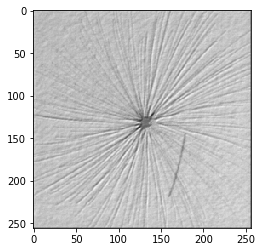

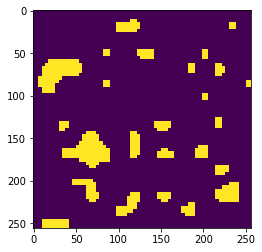

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f94d5ed2908>>
Traceback (most recent call last):
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/tchaton/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/tchaton/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/tchaton/.pyenv/versions/3.6.4/lib/py

RuntimeError: Expected object of type torch.cuda.ByteTensor but found type torch.cuda.FloatTensor for argument #2 'mask'

In [124]:
for i, data in enumerate(dataset):
    
    img_A = data['A']
    img_A = tensor2im(data['A'])
    plt.imshow(img_A)
    plt.show()
    
    mask = masks[0]
    plt.imshow(mask)
    plt.show()
    
    mask = mask2tensor(mask)
    model.mask_global = mask.byte()
    model.set_input(data)#_with_mask(data, mask)
    
    real_A = model.real_A
    real_A = tensor2im(real_A)
    plt.imshow(real_A[:, :, :3])
    plt.show()
    
    model.forward()  
    
    fake_B = model.get_current_visuals()['fake_B']
    print(fake_B.shape)
    fake_B = tensor2im(fake_B)
    plt.imshow(fake_B)
    plt.show()
    
    break

In [122]:
import scipy

In [ ]:
from scipy.signal import convolve2d

In [ ]:
k = 11
kernel = np.ones((k, k))/k**2

In [ ]:
from skimage.filters import *
from skimage.morphology import *

In [ ]:
from skimage.filters import gaussian
max_error = []
for i, data in enumerate(dataset):
    
    #print('i {}'.format(i))
    img = data['A']
    img_A = tensor2im(data['A'])
    plt.imshow(img_A)
    plt.show()
    
    fake_holder = np.zeros((256, 256, 3))
    fake_sum = np.zeros((256, 256, 1))
    
    for mask in masks:
        m = mask2tensor(mask)
        model.set_input_with_mask(data, m)
        model.forward()

        fake_B = model.fake_B
        fake_B = tensor2im(fake_B)
        #print(fake_B.min(), fake_B.max())
        #plt.imshow(fake_B)
        #plt.show()
        #break
        mask = mask[..., np.newaxis]
        m = np.tile(mask, (1, 1, 3))
        fake_holder[m == 1] += fake_B[m == 1]
        fake_sum += mask
    
    img_A = img_A.astype(np.float)
    img_A-=img_A.min()
    img_A/=img_A.max()

    rec = fake_holder/fake_sum.astype(np.float)

    rec-=rec.min()
    rec/=rec.max()    
    rec = hist_match(rec, img_A)
    #print(rec.min(), rec.max())
    img_A = img_A.astype(np.float)
    rec = rec.astype(np.float)
    
    plt.imshow(rec)
    plt.show()
    
    diff = np.square(img_A - rec).astype(np.float)

    
    diff = diff.mean(-1)
    print(np.max(diff), np.mean(diff))

    print(diff.shape)
    #diff[100:175, 100:175] = 0
    
    plt.imshow(diff)
    plt.show()
    diff[diff < np.percentile(diff, 99)] = 0
    diff[diff < threshold_otsu(diff[np.where(diff>0)])] = 0
    diff = convolve2d(diff, disk(5))
    diff[diff < threshold_otsu(diff[np.where(diff>0)])] = 0
    #diff = diff > 0
    plt.contourf(diff[::-1], cmap='jet')
    plt.show()
    break

In [47]:
plt.imshow(sobel(img_A.mean(-1)))

NameError: name 'sobel' is not defined

In [48]:
nin = 3
Gx = nn.Conv2d(nin, 1, kernel_size=(3, 3), padding=1)

In [49]:
Gx.weight.data.shape

torch.Size([1, 3, 3, 3])

In [50]:
gx = torch.Tensor([[1, 0, -1],
[2, 0, -2],
[1, 0, -1]])

In [51]:
Gx.weight.data

tensor([[[[-0.0574,  0.0613, -0.0600],
          [-0.1608,  0.1582,  0.1320],
          [ 0.0833, -0.0578, -0.0556]],

         [[ 0.0524, -0.0379, -0.1521],
          [ 0.1662,  0.1020,  0.1167],
          [-0.1160, -0.0544, -0.0982]],

         [[ 0.1245,  0.1083,  0.1753],
          [-0.1243, -0.0927,  0.0855],
          [ 0.0345,  0.0969,  0.0350]]]])

In [52]:
Gx.weight.data[0]

tensor([[[-0.0574,  0.0613, -0.0600],
         [-0.1608,  0.1582,  0.1320],
         [ 0.0833, -0.0578, -0.0556]],

        [[ 0.0524, -0.0379, -0.1521],
         [ 0.1662,  0.1020,  0.1167],
         [-0.1160, -0.0544, -0.0982]],

        [[ 0.1245,  0.1083,  0.1753],
         [-0.1243, -0.0927,  0.0855],
         [ 0.0345,  0.0969,  0.0350]]])

In [53]:
depthwise.weight.data.tolist()

NameError: name 'depthwise' is not defined

In [54]:
img = torch.FloatTensor(torch.randn(1, 3, 32, 32))

In [55]:
Gx(img)

tensor([[[[ 0.6490,  0.1910,  0.0003,  ...,  0.2069, -0.3470, -0.0269],
          [-0.5513,  0.6157, -0.1885,  ...,  0.1916,  0.5043,  0.1038],
          [ 0.7396, -0.0732, -0.2582,  ...,  0.0563,  0.4245,  0.1635],
          ...,
          [-0.0040,  0.3905,  0.3970,  ...,  0.0372,  0.6464,  0.3065],
          [ 0.3519, -0.4332, -0.5845,  ..., -0.3326,  0.3504,  1.0338],
          [-0.0883, -0.3375,  0.4454,  ..., -0.8369, -0.1705, -0.3929]]]],
       grad_fn=<ThnnConv2DBackward>)

In [56]:
def args_displayer(func):
    def wrapper(*args, **kwargs):
        print(func.__name__, args, kwargs)
        return func(*args, **kwargs)
    return wrapper

In [57]:
@args_displayer
def he(hello=True):
    print(hello)
    pass

In [58]:
he(hello=False)

he () {'hello': False}
False


In [92]:
import models.modules.losses as losses

In [103]:
target = losses.to_categorical(data['A'], 0, mask)

In [104]:
mask.shape

torch.Size([1, 1, 256, 256])

In [105]:
target.shape

torch.Size([1, 3, 256, 256])

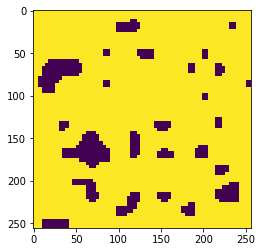

In [108]:
plt.imshow(target[0, 2])